In [1]:
from shapely.geometry import Polygon
from model.RegionsCalcs import create_regions
from model.RegionsPlotter import standard_plot, plot_algorithm_result
import numpy as np
from model.NetworkGraph import CompleteGraph
from numpy import random
import matplotlib.pyplot as plt
from tecno_analysis.dimensioning_algorithm_tecnoechonomics import DimensioningAlgorithmTecnoeconomics
from tecno_analysis.dimensioning_algorithm_associations import NodePositionsAlgorithm
import math

In [2]:
# Import the network
graph = CompleteGraph.of_sources("../Passion_Xtreme_III.mat", "../NameTypes.xlsx")

Discarded nodes: 39
Discarded links: 0
Links: 174
Nodes: 154

*-*-* Printing information about the imported network *-*-*

Num nodes: 154
Num links: 174
Num HL4: 20
Num HL5: 134
Average distance: 2.58
Max distance (km): 22.00
Min distance (km): 0.18
Average degree: 2.27
Min degree: 1
Max degree: 10
Average degree HL4: 1.95
Average degree HL5: 2.32
Total bidirectional link length (km): 448.84


In [3]:
num_nodes = len(graph.nodes)
tentative_nodes_for_femtocells = np.zeros(num_nodes, dtype=int)

pick_prob = 0.5
for i, node in enumerate(graph.nodes):
    if node.type == "HL5" and random.random() < pick_prob:
        tentative_nodes_for_femtocells[i] = 1
        
tentative_range_for_femtocells = np.ones(num_nodes)
base_area = graph.network_polygon_bounds
node_power = np.array([0.1 if node.type == "HL5" else 40 for node in graph.nodes])


In [4]:
node_adjacencies_matrix = np.array(graph.adjacency_matrix)
node_positions = np.array([node.pos for node in graph.nodes])
node_type_hl4 = np.array([1 if node.type == "HL4" else 0 for node in graph.nodes])
node_type_hl5 = np.array([1 if node.type == "HL5" else 0 for node in graph.nodes])
traffic_injection = np.array([node.estimated_traffic_injection for node in graph.nodes])
fixed_nodes_for_hpld = node_type_hl4.copy()
tentative_nodes_for_hpld = node_type_hl5.copy()
tentative_nodes_for_femtocells = node_type_hl5.copy()
tentative_range_for_femtocells = np.ones(num_nodes)
nodes_for_macrocells = node_type_hl4.copy()
range_for_macrocells = np.ones(num_nodes)
alpha_loss = 3
max_runtime_seconds = 180.0
euclidean_to_km_scale = 1.0
power_for_hpld = np.ones(num_nodes) * 5
power_for_femtocells = np.ones(num_nodes) * 0.1
power_for_macrocells = np.ones(num_nodes) * 40
alpha = 0.31
base_area = graph.network_polygon_bounds



In [5]:
fixed_femtos = sum(node_type_hl4) * 5
print(fixed_femtos)
free_femtos = sum(node_type_hl5) - fixed_femtos
print(free_femtos)

num_new_hplds = math.ceil(free_femtos / 5)
print(num_new_hplds)

hl5_indexes = np.where(tentative_nodes_for_femtocells == 1)[0]
print(hl5_indexes)


random_hl5s = np.random.choice(hl5_indexes, num_new_hplds, replace=False)
print(random_hl5s)

100
34
7
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133]
[ 61  82   6  39  90  30 111]


In [6]:
nodes_with_hpld = node_type_hl4.copy()
nodes_with_hpld[random_hl5s] = 1
print(f'Total HPLDs: {sum(nodes_with_hpld)}')
nodes_with_hpld

Total HPLDs: 27


array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [7]:
nodes_with_femtocells = node_type_hl5
nodes_with_femtocells

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [8]:
node_adjacencies_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
algorithm = NodePositionsAlgorithm(node_type_hl5, node_adjacencies_matrix, node_type_hl4, node_type_hl5)

In [10]:
best_hpld_positions, best_associations = algorithm.determine_best_hpld_positions()

In [11]:
print(sum(best_hpld_positions))
best_hpld_positions

22


array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [12]:
print(best_associations.shape)
print(sum(best_associations).sum())
best_associations

(154, 154)
110


array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

# Plot the femtocells

In [13]:
# Common scenario for both cases
# Params
p_tx_fem = 10       # W

femotcells = [
    [node_positions[node][0], node_positions[node][1], 0.1] for node in range(num_nodes) if nodes_with_femtocells[node] == 1
]

In [14]:

regions, _unsold = create_regions(
    np.array(femotcells),
    alpha_loss, 
    polygon_bounds=base_area,
)

In [15]:
regions

{133: <POLYGON ((7.394 18.329, 7.389 18.231, 7.389 18.231, 7.375 18.134, 7.375 18....>,
 132: <POLYGON ((19.618 7.017, 19.625 7.011, 19.625 7.011, 19.691 6.938, 19.691 6....>,
 131: <POLYGON ((4.222 15.024, 4.222 15.024, 4.222 15.024, 4.222 15.024, 4.222 15....>,
 130: <POLYGON ((13.039 22.89, 13.039 22.89, 13.039 22.89, 13.039 22.89, 13.039 22...>,
 129: <POLYGON ((6.236 27.543, 6.233 27.529, 6.233 27.529, 6.21 27.434, 6.21 27.43...>,
 128: <POLYGON ((13.368 32.679, 13.368 32.679, 13.368 32.679, 13.368 32.679, 13.36...>,
 127: <POLYGON ((19.646 23.06, 19.646 23.06, 19.646 23.06, 19.646 23.06, 19.646 23...>,
 126: <POLYGON ((11.554 14.478, 11.554 14.477, 11.554 14.477, 11.587 14.385, 11.58...>,
 125: <POLYGON ((15.643 30.655, 15.589 30.606, 15.589 30.606, 15.51 30.548, 15.51 ...>,
 124: <POLYGON ((21.869 28.363, 21.835 28.368, 21.835 28.368, 21.739 28.392, 21.73...>,
 123: <POLYGON ((13.753 17.236, 13.714 17.153, 13.714 17.153, 13.663 17.069, 13.66...>,
 122: <POLYGON ((10.451 31.361, 

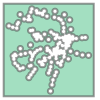

In [ ]:
_unsold

In [17]:
area = Polygon(base_area)
print(f'Complete region area:{area.area}')
print(f'Uncovered area:{_unsold.area}')
print(f'Covered area:{area.area - _unsold.area} ({(area.area - _unsold.area) / area.area * 100:.2f}%)')

Complete region area:1230.7650240111575
Uncovered area:922.988144160848
Covered area:307.77687985030946 (25.01%)


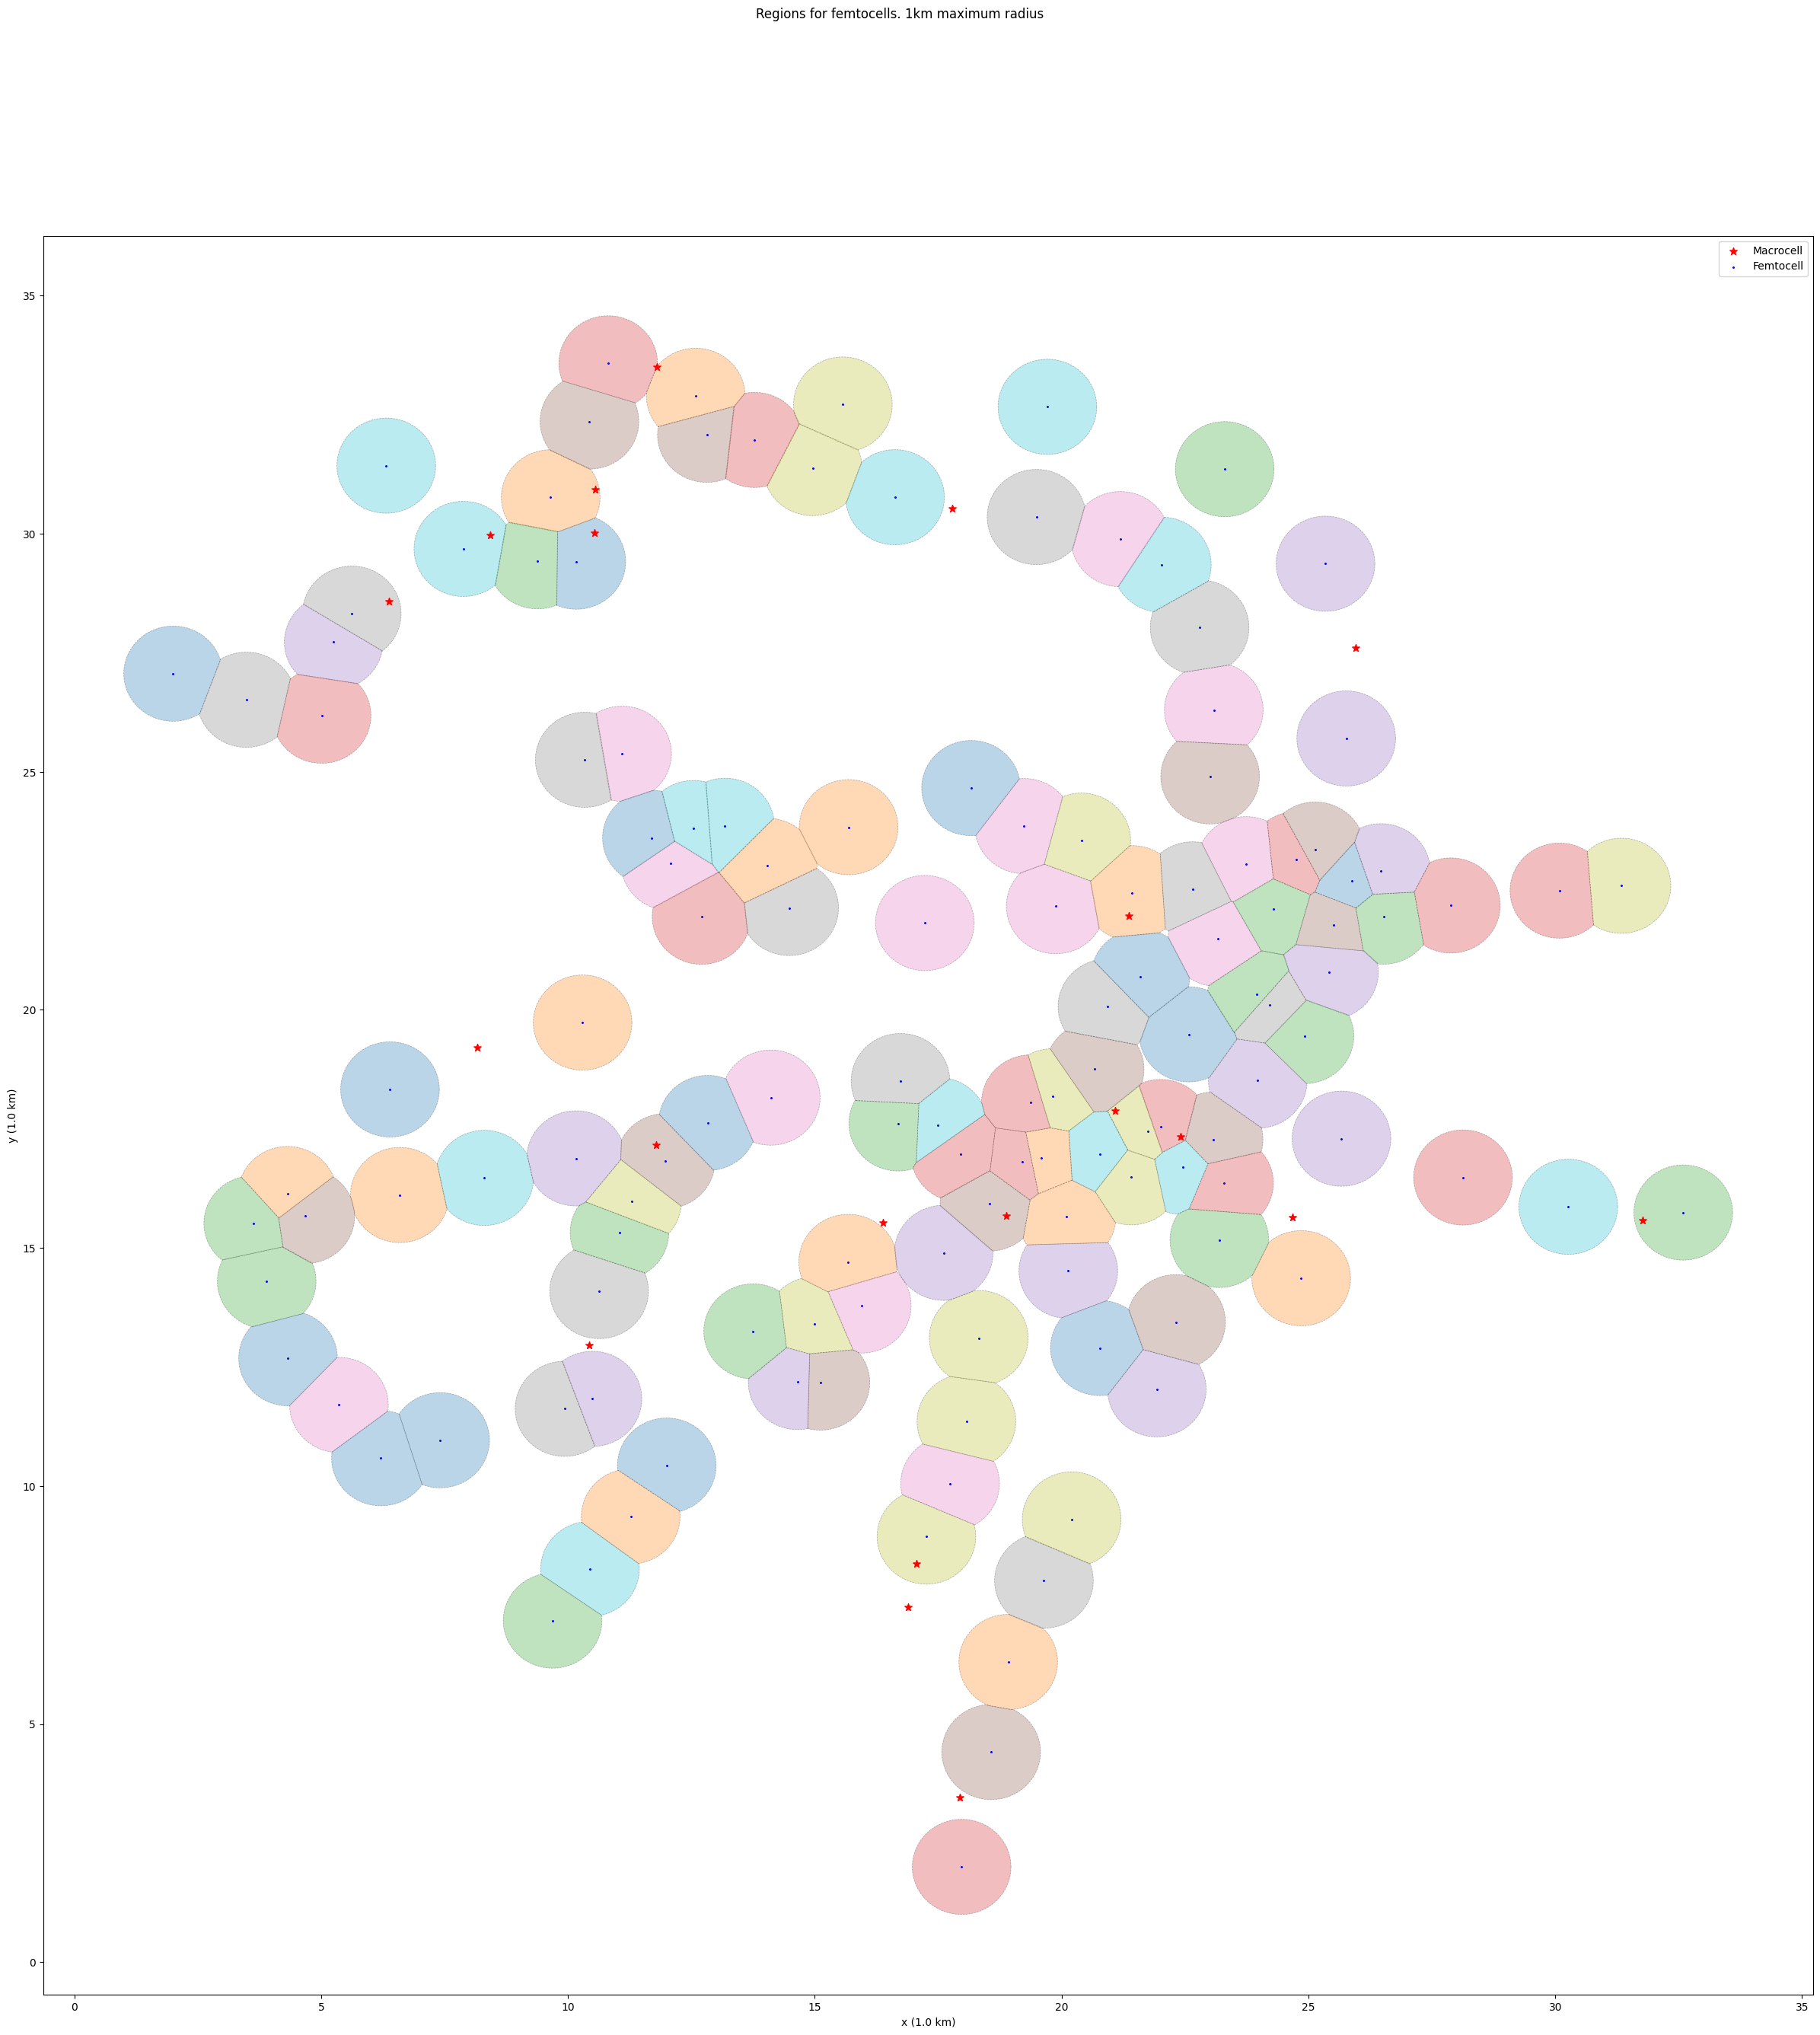

(<Figure size 3000x3000 with 1 Axes>,
 <Axes: xlabel='x (1.0 km)', ylabel='y (1.0 km)'>)

In [18]:
standard_plot(
    regions, 
    graph.nodes, 
    1.0, 
    femtocell_config={"marker": ".", "s": 5},
    plot_config={"title": "Regions for femtocells. 1km maximum radius", "figsize": (30, 30)},
)

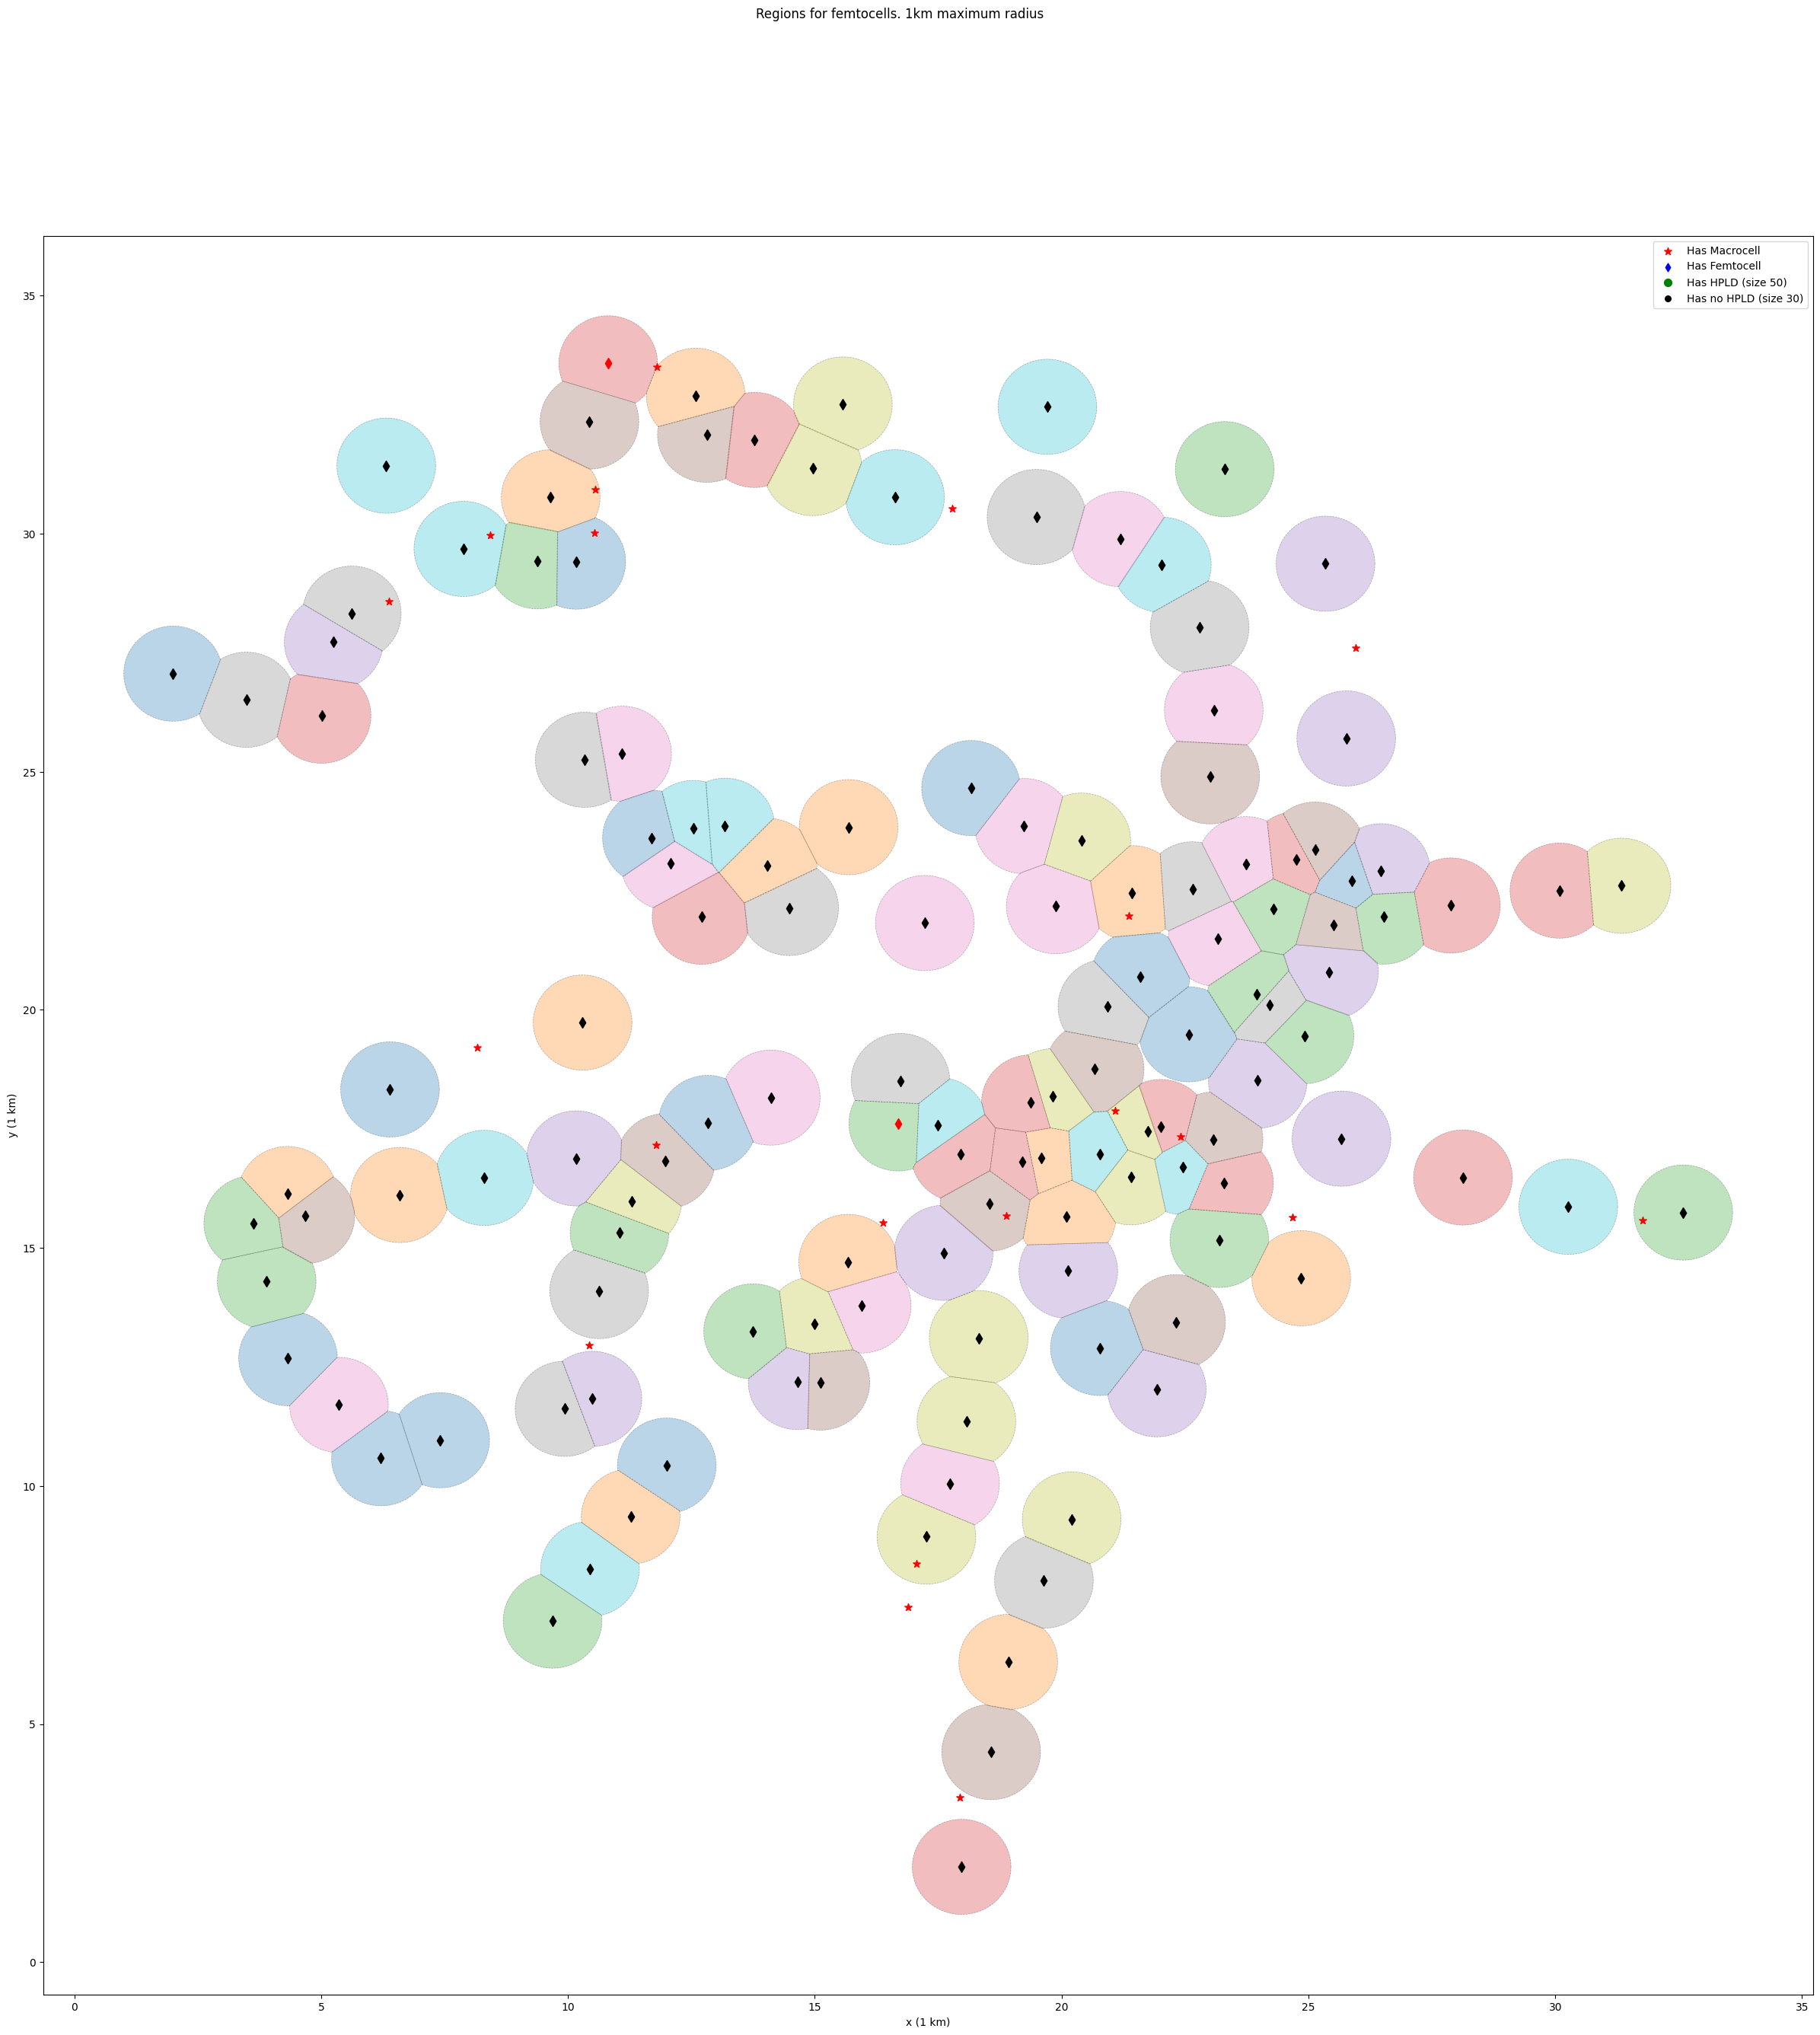

(<Figure size 3000x3000 with 1 Axes>,
 <Axes: xlabel='x (1 km)', ylabel='y (1 km)'>)

In [19]:
# (x, y, has_macrocell, has_femtocell, has_hpld)
nodes = [
    (node_positions[i][0], node_positions[i][1], node_type_hl4[i] == 1, nodes_with_femtocells[i] == 1, best_hpld_positions[i] == 1)
    for i in range(num_nodes)
]

plot_algorithm_result(
    regions,
    nodes,
    plot_config={"title": "Regions for femtocells. 1km maximum radius", "figsize": (30, 30)},
)

In [20]:
# Plotting the associations HPLD-Femtocell



In [21]:
print(f'Total HPLDs: {sum(nodes_with_hpld)}')
print(f'Total Femtocells: {sum(nodes_with_femtocells)}')
print(f'Deployed BW Capacity: {sum(nodes_with_femtocells)} Gbps')
print(f'Estimated Throughput: {sum(traffic_injection[nodes_with_femtocells == 1])/1000:.2f} Gbps')
print(f'Total Covered Area: {area.area - _unsold.area:.2f} ({(area.area - _unsold.area) / area.area * 100:.2f}%)')

Total HPLDs: 27
Total Femtocells: 134
Deployed BW Capacity: 134 Gbps
Estimated Throughput: 77.75 Gbps
Total Covered Area: 307.78 (25.01%)


In [22]:
from model.MatFileStorageParser import FileModel

In [23]:
BaseStations = []

# Add Macrocells (HPLDs)
for node in range(len(node_positions)):
    if nodes_with_hpld[node] == 1:
        BaseStations.append((node_positions[node][0], node_positions[node][1], 40))

NMacroCells = len(BaseStations)
        
# Add Femtocells
for node in range(len(node_positions)):
    if nodes_with_femtocells[node] == 1:
        BaseStations.append((node_positions[node][0], node_positions[node][1], 0.1))
        
NFemtoCells = len(BaseStations) - NMacroCells


# FileModel.save_file_basic("UC2-S2.mat", BaseStations, NFemtoCells, NMacroCells)

In [24]:
from model.RegionsPlotter import plot_regions_deliverable

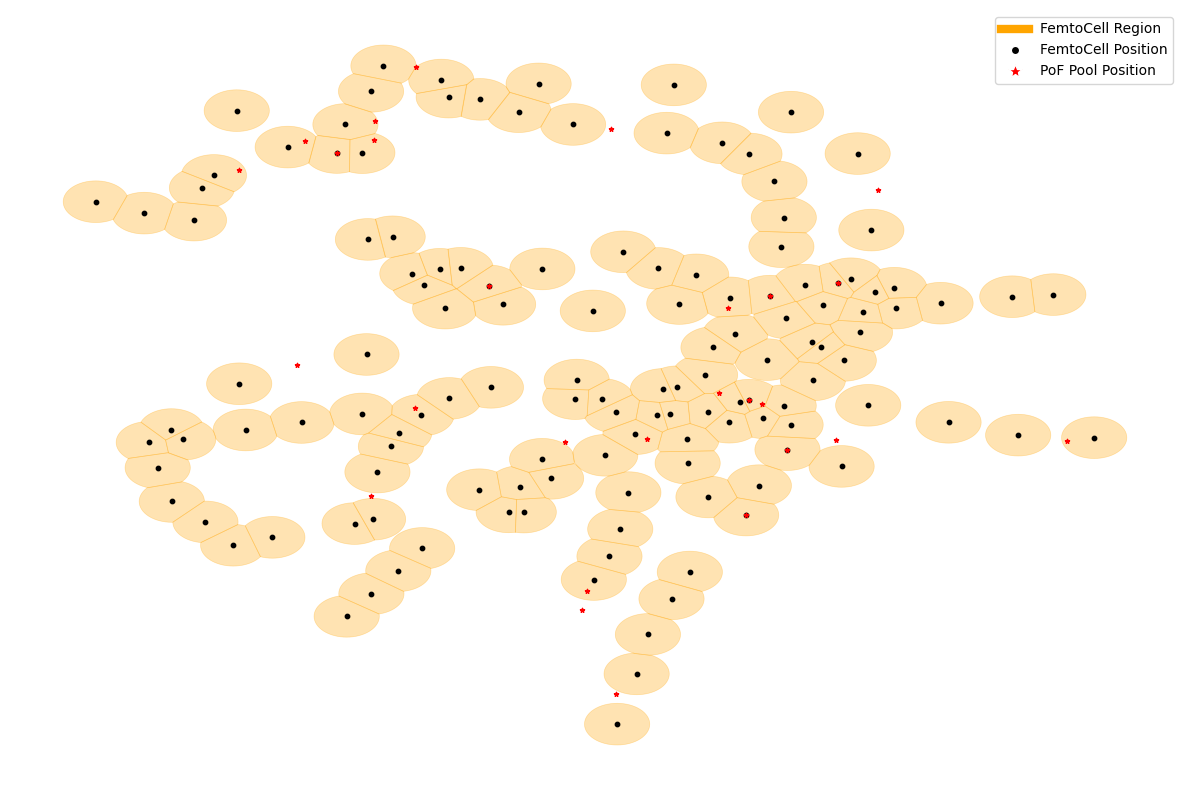

In [25]:
base_stations = [
    (node_positions[i][0], node_positions[i][1], 1) for i in range(len(graph.nodes))
]
fig, ax = plot_regions_deliverable(
    base_stations,
    nodes_with_femtocells,
    nodes_with_hpld,
    [],
    regions,
    title="UC1 - PoF Pools on HL4",
)

/home/elig/Documents/GitHub/PoF_Simulator/model/RegionsPlotter.py:342: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  _ax.annotate(str(i), (_nodes[i][0], _nodes[i][1]), textcoords='offset points', fontsize=8)
/home/elig/Documents/GitHub/PoF_Simulator/model/RegionsPlotter.py:360: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  _ax.annotate(str(i), (_nodes[i][0], _nodes[i][1]), textcoords='offset points', fontsize=8)


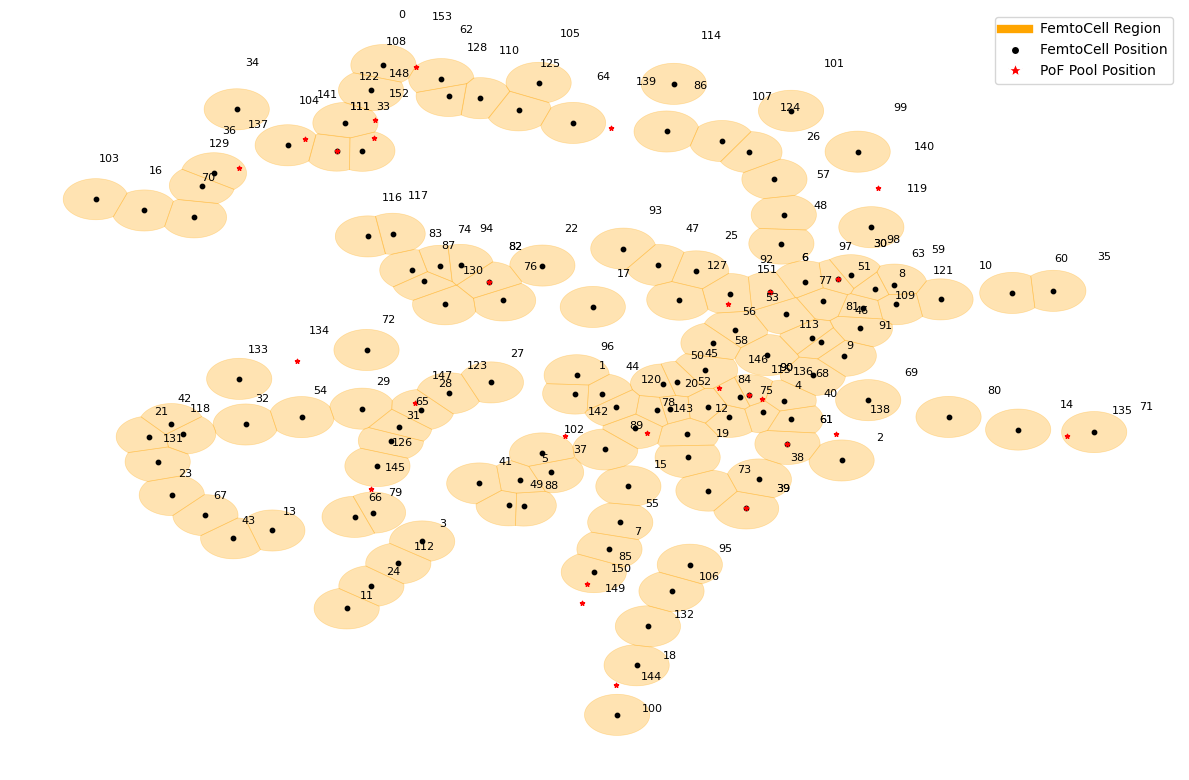

In [26]:
base_stations = [
    (node_positions[i][0], node_positions[i][1], 1) for i in range(len(graph.nodes))
]
fig, ax = plot_regions_deliverable(
    base_stations,
    nodes_with_femtocells,
    nodes_with_hpld,
    [],
    regions,
    title="UC1 - PoF Pools on HL4",
    draw_node_names=True,
)